# Olist EDA & Market Basket Analysis

In [1]:
# Filtering out the warnings

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
import datetime as dt
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [4]:
# Reading all the tables
df = pd.read_excel (r'Olist_dataset.xlsx')
order = pd.read_excel (r'Olist_dataset.xlsx', sheet_name='orders')
order_items = pd.read_excel (r'Olist_dataset.xlsx', sheet_name='order_items')
customers = pd.read_excel (r'Olist_dataset.xlsx', sheet_name='customers')
payments = pd.read_excel (r'Olist_dataset.xlsx', sheet_name='payments')
products = pd.read_excel (r'Olist_dataset.xlsx', sheet_name='products')

## Orders Dataset Overview & Data Cleaning

In [5]:
print(order)

                               order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  7c396fd4830fd04220f754e42b4e5bff   
1      53cdb2fc8bc7dce0b6741e2150273451  af07308b275d755c9edb36a90c618231   
2      47770eb9100c2d0c44946d9cf07ec65d  3a653a41f6f9fc3d2a113cf8398680e8   
3      949d5b44dbf5de918fe9c16f97b45f8a  7c142cf63193a1473d2e66489a9ae977   
4      ad21c59c0840e6cb83a9ceb5573f8159  72632f0f9dd73dfee390c9b22eb56dd6   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  6359f309b166b0196dbf7ad2ac62bb5a   
99437  63943bddc261676b46f01ca7ac2f7bd8  da62f9e57a76d978d02ab5362c509660   
99438  83c1379a015df1e13d02aae0204711ab  737520a9aad80b3fbbdad19b66b37b30   
99439  11c177c8e97725db2631073c19f07b62  5097a5312c8b157bb7be58ae360ef43c   
99440  66dea50a8b16d9b4dee7af250b4be1a5  60350aa974b26ff12caad89e55993bd6   

      order_status order_purchase_timestamp   order_approved_at  \
0       

In [6]:
# overview to the data
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [7]:
# check for null values
order.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_timestamp        2965
order_estimated_delivery_date       0
dtype: int64

In [8]:
# we have taken median of differences between order_approved_at and order_purchased and then filled the nan values with sum of order_purchased and diff
diff = (order['order_approved_at'] - order['order_purchase_timestamp']).median()
order['order_approved_at'].fillna(order['order_purchase_timestamp'] + diff,inplace=True)

In [9]:
# we have taken median of differences between order_delivered_carrier_date and order_approved_at and then filled the nan values with sum of order_approved_at and diff
diff = (order['order_delivered_timestamp'] - order['order_approved_at']).median()
order['order_delivered_timestamp'].fillna(order['order_approved_at'] + diff,inplace=True)

In [10]:
# creating one more column delayed or not where 0=within time and 1=delayed
order['delayed'] = np.where(order['order_delivered_timestamp']>order['order_estimated_delivery_date'],1,0)

In [11]:
# creating new column ie. delivery time duration = time duration between delivered to customer date and purchase timestamp
order['delivery_time_duration'] = order['order_delivered_timestamp'] - order['order_purchase_timestamp']

In [12]:
# check for duplicated values
order.duplicated().sum()

0

In [13]:
order.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,0,13 days 18:46:08
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,0,9 days 09:27:40
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,0,13 days 05:00:36
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,0,2 days 20:58:23


## Items Dataset Overview & Data Cleaning

In [14]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [15]:
# description of data
order_items.describe()

,order_item_id,price,shipping_charges
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


## Customers Dataset Overview & Data Cleaning

In [16]:
# overview to the data
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [17]:
# description of data
customers.describe()


,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


In [18]:
customers.shape

(99441, 4)

In [19]:
# no null values
customers.isnull().sum()

customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [20]:
# no. of duplicate values
customers['customer_id'].duplicated().sum()

3345

## Products Dataset Overview & Cleaning

In [21]:
products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [22]:
# describing product table
products.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
max,40425.000000,105.000000,105.000000,118.000000


In [23]:
# check for null values
products.isnull().sum()

product_id                 0
product_category_name    170
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

In [24]:
# filling minute null values 
products['product_weight_g'].fillna(products['product_weight_g'].mean(),inplace=True)
products['product_length_cm'].fillna(products['product_length_cm'].mean(),inplace=True)
products['product_height_cm'].fillna(products['product_height_cm'].mean(),inplace=True)
products['product_width_cm'].fillna(products['product_width_cm'].mean(),inplace=True)

## Payments Dataset Overview & Cleaning

In [25]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [26]:
# check for null values
payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [27]:
# describing product table
payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


### Merging DataFrames

In [28]:
ord_prod = pd.merge(order_items, products, on="product_id", how="outer", indicator=True)
ord_prod.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,toys,650.0,28.0,9.0,14.0,both
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,toys,650.0,28.0,9.0,14.0,both
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,toys,650.0,28.0,9.0,14.0,both
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,toys,650.0,28.0,9.0,14.0,both
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,toys,650.0,28.0,9.0,14.0,both


In [29]:
cust_ord =pd.merge(order, customers, on="customer_id", how="outer", indicator=True)
cust_ord.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration,customer_zip_code_prefix,customer_city,customer_state,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both
2,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,0,1 days 07:53:42,3149,sao paulo,SP,both
3,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,0,1 days 07:53:42,3149,sao paulo,SP,both
4,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,0,13 days 18:46:08,47813,barreiras,BA,both


In [30]:
ord_pay = pd.merge(cust_ord, payments, on="order_id", how="outer")
ord_pay.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration,customer_zip_code_prefix,customer_city,customer_state,_merge,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both,2.0,voucher,1.0,18.59
3,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both,1.0,credit_card,1.0,18.12
4,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,sao paulo,SP,both,3.0,voucher,1.0,2.00


In [31]:
ord_final = pd.merge(ord_pay, ord_prod, on="order_id", how="outer")
ord_final.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration,customer_zip_code_prefix,...,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge_y
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0,both
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0,both
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0,both
3,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0,both
4,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0,both


In [32]:
ord_final = ord_final.drop({'_merge_x','_merge_y'},axis='columns')

In [33]:
ord_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128585 entries, 0 to 128584
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       128585 non-null  object         
 1   customer_id                    128585 non-null  object         
 2   order_status                   128585 non-null  object         
 3   order_purchase_timestamp       128585 non-null  datetime64[ns] 
 4   order_approved_at              128585 non-null  datetime64[ns] 
 5   order_delivered_timestamp      128585 non-null  datetime64[ns] 
 6   order_estimated_delivery_date  128585 non-null  datetime64[ns] 
 7   delayed                        128585 non-null  int64          
 8   delivery_time_duration         128585 non-null  timedelta64[ns]
 9   customer_zip_code_prefix       128585 non-null  int64          
 10  customer_city                  128585 non-null  object  

In [34]:
ord_final.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_timestamp           0
order_estimated_delivery_date       0
delayed                             0
delivery_time_duration              0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
order_item_id                     987
product_id                        987
seller_id                         987
price                             987
shipping_charges                  987
product_category_name            1463
product_weight_g                  987
product_length_cm                 987
product_height_cm                 987
product_width_cm                  987
dtype: int64

In [35]:
# Most number of product delivered
ord_final.product_category_name.value_counts().nlargest(10)

toys                     95727
health_beauty             3389
bed_bath_table            3094
sports_leisure            2641
furniture_decor           2504
computers_accessories     2461
housewares                1926
watches_gifts             1685
telephony                 1318
garden_tools              1187
Name: product_category_name, dtype: int64

toys                        95727
health_beauty                3389
bed_bath_table               3094
sports_leisure               2641
furniture_decor              2504
computers_accessories        2461
housewares                   1926
watches_gifts                1685
telephony                    1318
garden_tools                 1187
auto                         1183
cool_stuff                   1070
perfumery                     933
baby                          873
electronics                   762
office_furniture              740
stationery                    678
fashion_bags_accessories      556
pet_shop                      556
home_appliances               308
Name: product_category_name, dtype: int64

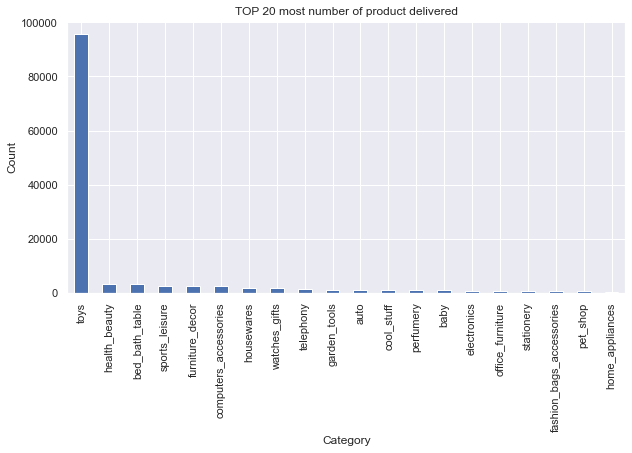

In [36]:
%matplotlib inline 
sns.set(color_codes=True)
b=ord_final.product_category_name.value_counts().nlargest(20)
# Checking most ordered product
ord_final.product_category_name.value_counts().nlargest(20).plot(kind='bar', figsize=(10,5))
plt.title("TOP 20 most number of product delivered")
plt.ylabel('Count')
plt.xlabel('Category');
b


In [37]:
#most number of product ordered vs revenue
prod_rev=ord_final.groupby(by=["product_category_name"])["price"].sum()

0                      toys
1             health_beauty
2             watches_gifts
3            sports_leisure
4            bed_bath_table
5     computers_accessories
6           furniture_decor
7                cool_stuff
8                housewares
9                      auto
10             garden_tools
11         office_furniture
12                     baby
13                perfumery
14                telephony
15                 pet_shop
16               stationery
17         small_appliances
18                computers
19        home_appliances_2
Name: product_category_name, dtype: object

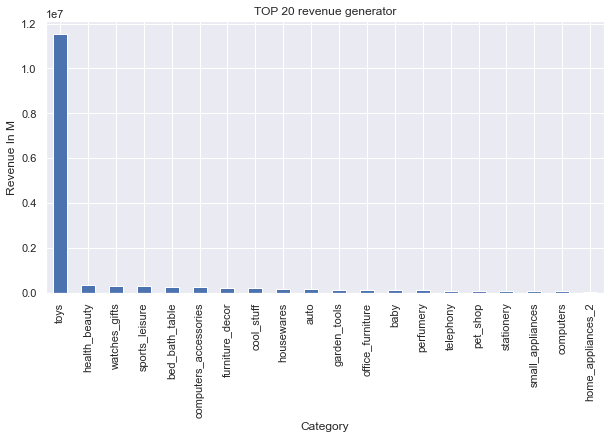

In [38]:
# Top 10 revenue genrated products
a=pd.DataFrame(prod_rev.nlargest(20)).reset_index()
prod_rev.nlargest(20).plot(kind='bar', figsize=(10,5))
plt.title("TOP 20 revenue generator")
plt.ylabel('Revenue In M')
plt.xlabel('Category');

a.product_category_name

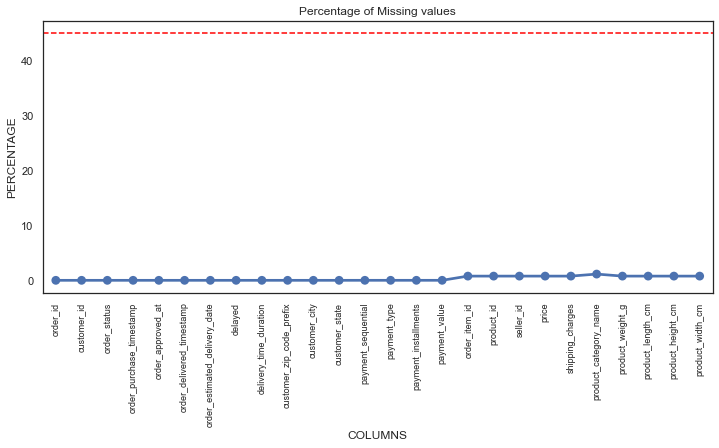

In [39]:
#plotting the null value percentage
sns.set_style("white")
fig = plt.figure(figsize=(12,5))
null_lead = pd.DataFrame((ord_final.isnull().sum())*100/ord_final.shape[0]).reset_index()
ax = sns.pointplot("index",0,data=null_lead)
plt.xticks(rotation =90,fontsize =9)
ax.axhline(45, ls='--',color='red')
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
plt.show()

#### Strategy: Here we can see that all columns have below 45% of null value, so we don't have to drop them

In [40]:
ord_final.to_excel(r'Market and Retail Analysis_ Final.xlsx', sheet_name='Retail_dataset.xlsx', index = False)


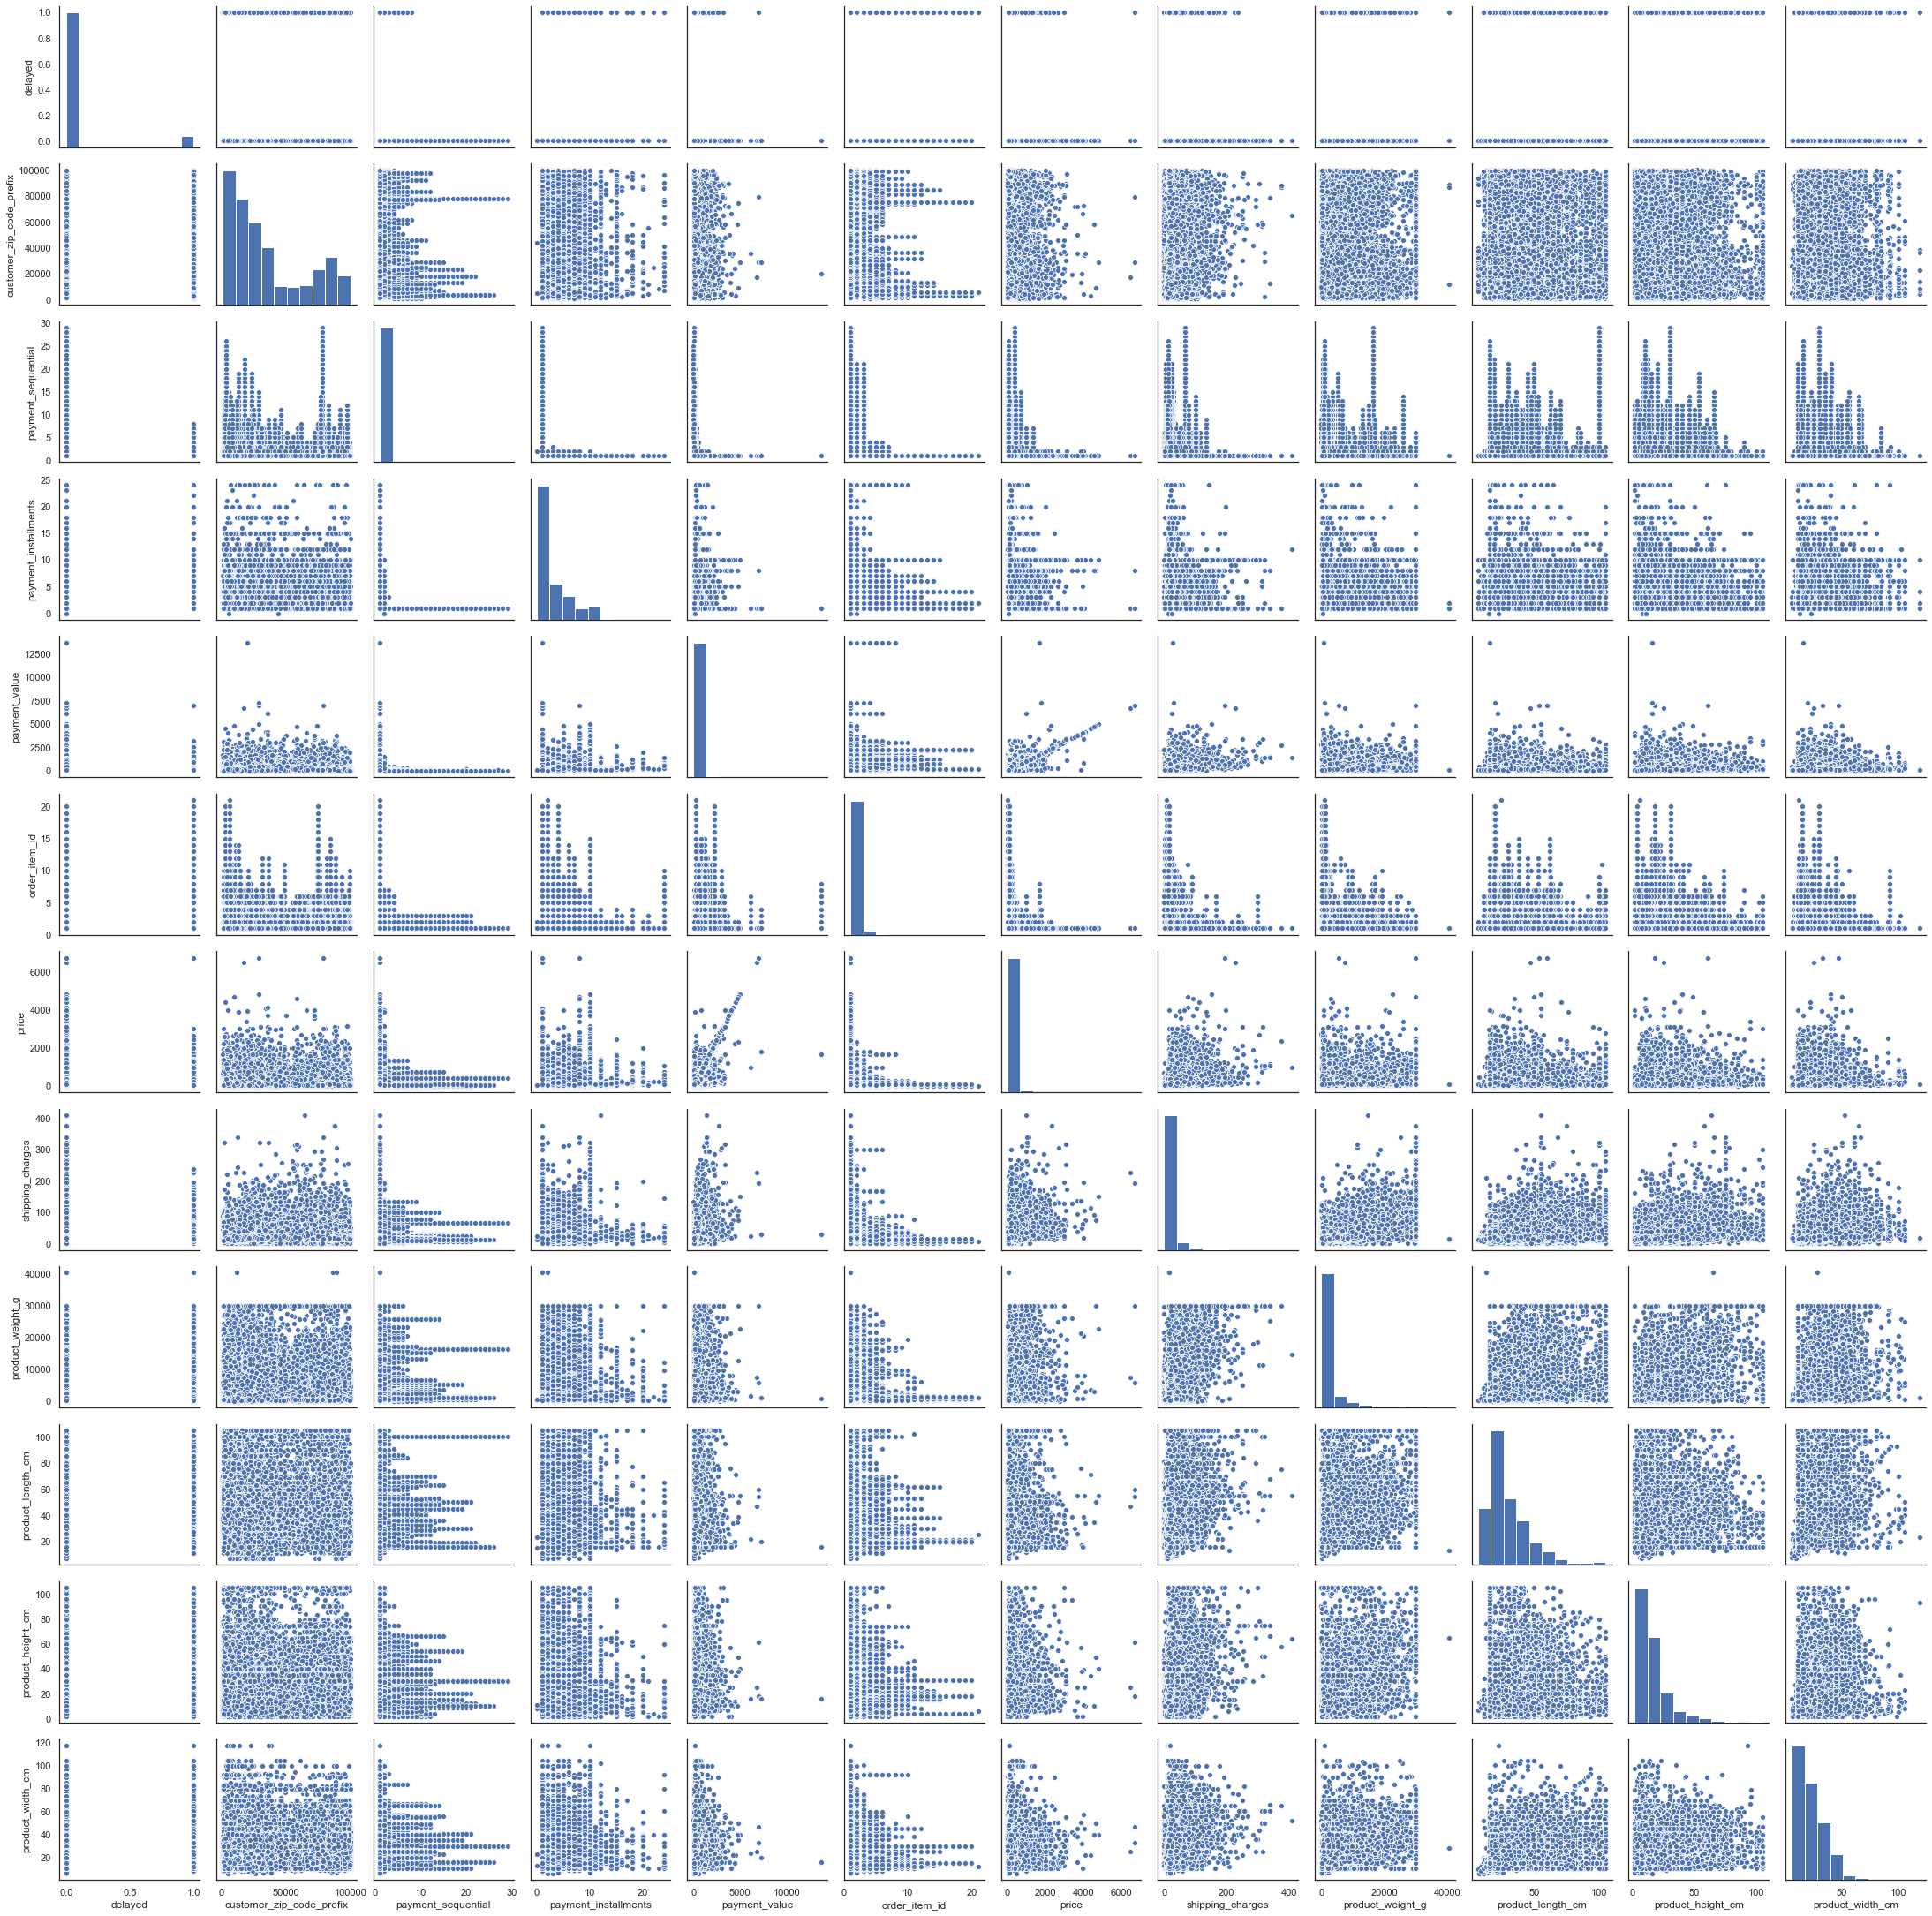

In [41]:
sns.pairplot(ord_final)

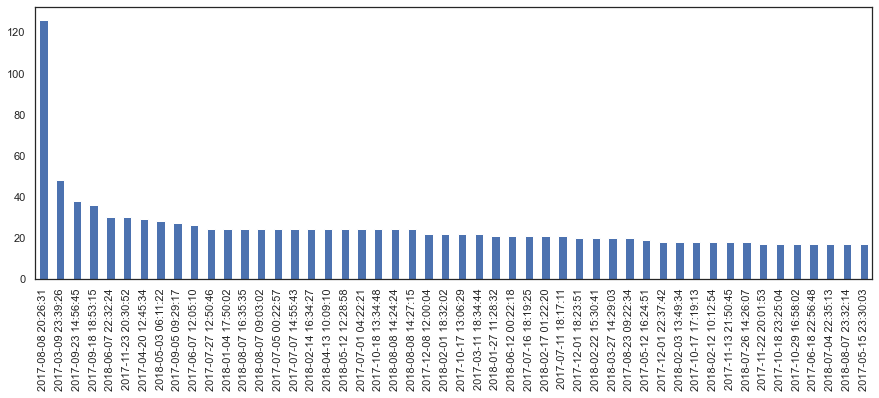

In [42]:
# we need to understand the growth of purchase from olist store within these years.
ord_final['order_purchase_timestamp'].value_counts()[:50].plot(kind='bar', figsize=(15,5))

In [43]:
ord_final['payment_type'].value_counts()

credit_card    94675
wallet         24916
voucher         7199
debit_card      1788
not_defined        4
Name: payment_type, dtype: int64

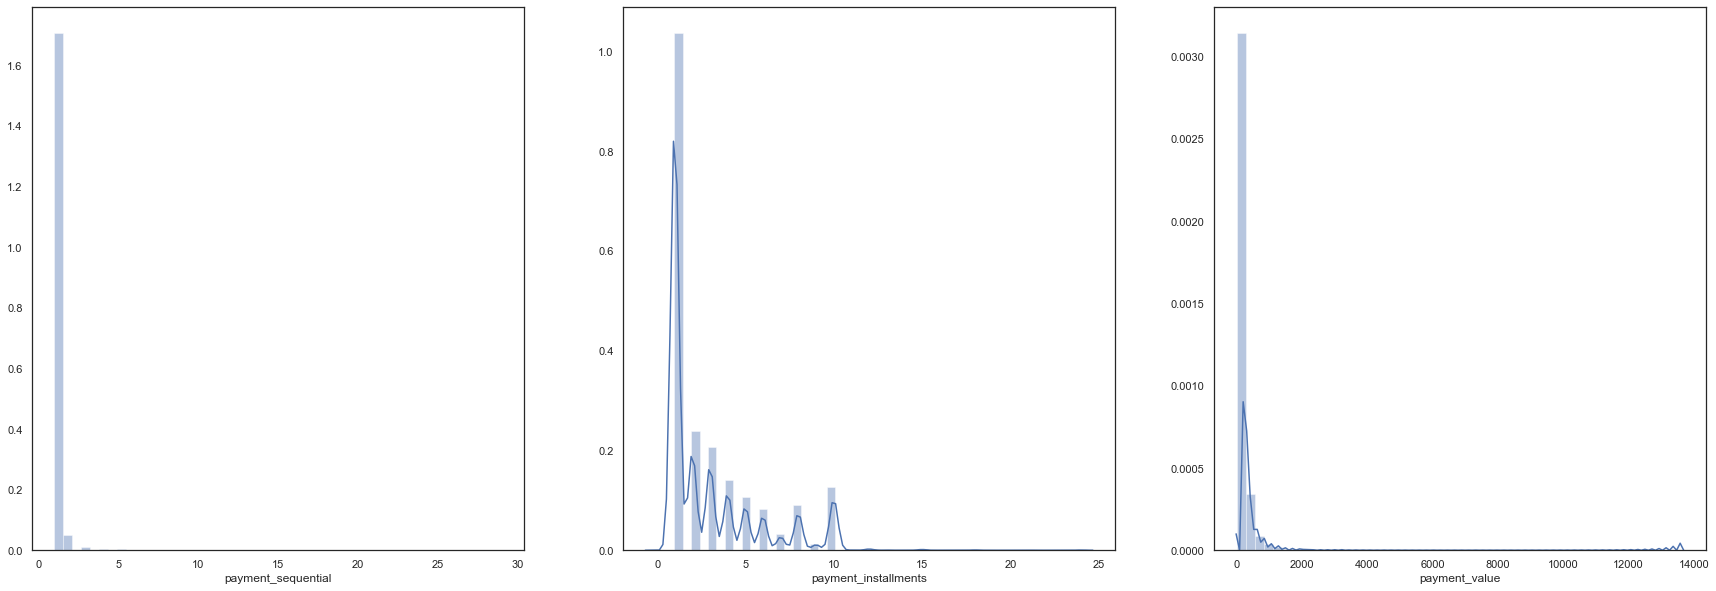

In [44]:
data_num = ['payment_sequential','payment_installments','payment_value']
figure = plt.figure(figsize=(30,10))
itr=1
for i in data_num:
    plt.subplot(1,3,itr)
    sns.distplot(ord_final[i])
    itr+=1
plt.show()

In [45]:
pd.DataFrame(ord_final['payment_sequential'].value_counts()).head(10)

,payment_sequential
1.0,122936
2.0,3710
3.0,731
4.0,353
5.0,212
6.0,150
7.0,105
8.0,72
9.0,58
10.0,49


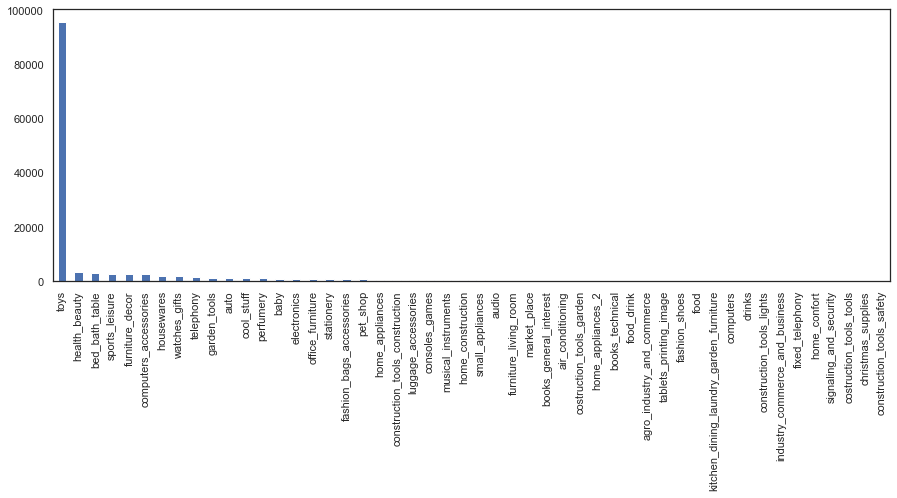

In [46]:
ord_final['product_category_name'].value_counts()[:50].plot(kind='bar', figsize=(15,5))

### Insight 1: 
The most common itemsets consist of a single item.

### Insight 2: 
There's a long tail of categories that consist of infrequently purchased items.

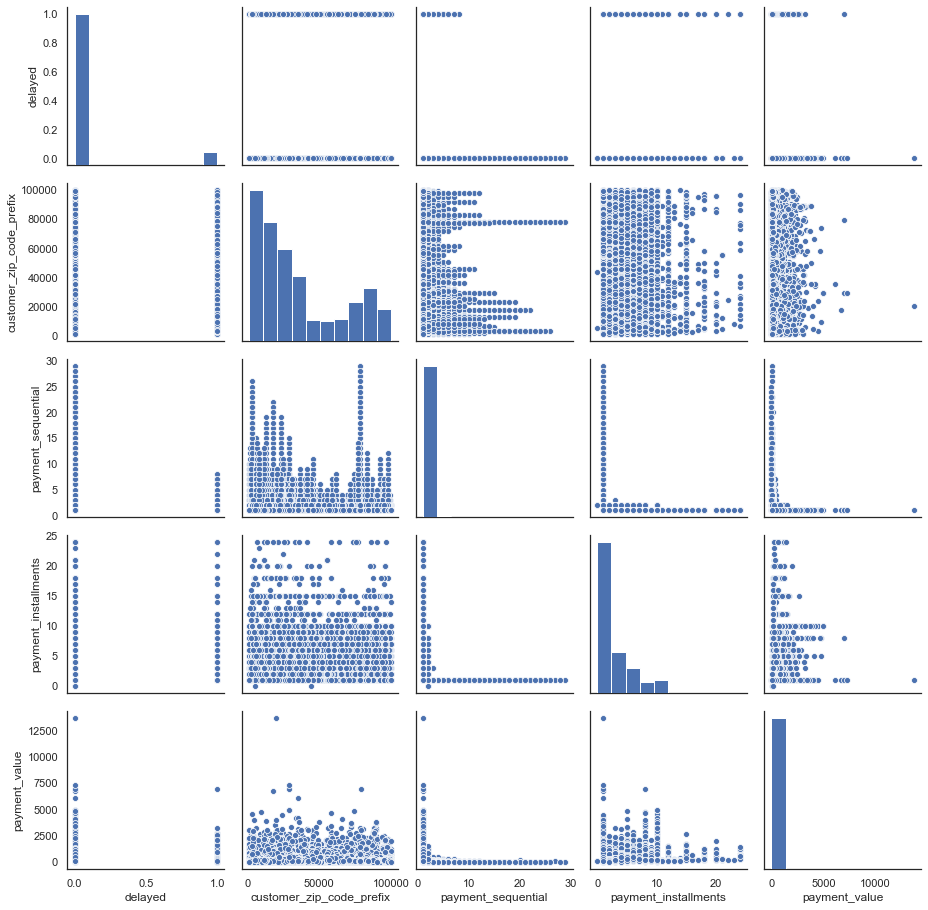

In [47]:
sns.pairplot(ord_pay)

### Correlation between features

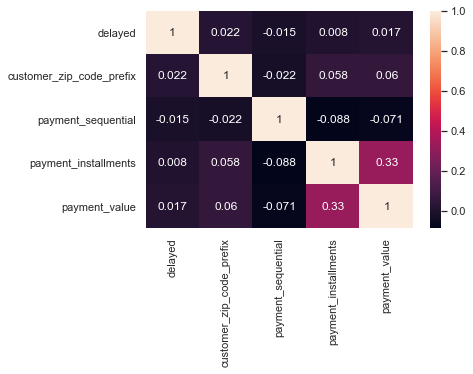

In [48]:
sns.heatmap(ord_pay.corr(),annot=True)

### RFM Modelling:
Todo the RFM analysis, we need to create 3 freatures from the data:

1. Recency: Latest date- last purchase date
2. Frequency: Total no. of transactions made by a single customer (count of order id)
3. Monetary: Total value of transacted sales by each customer.

#### Recency

In [49]:
#find the last date on which customer made the purchase
recency=pd.DataFrame(ord_final.groupby('product_id')['order_purchase_timestamp'].max().reset_index())

In [50]:
recency['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

In [51]:
#I take the maximum date of purchase made by customers as the date to calculate the recency of the purchase
#2018-10-17
recency['recent_days']=(recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']).dt.days
recency

,product_id,order_purchase_timestamp,recent_days
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20 18:45:21,105
1,00088930e925c41fd95ebfe695fd2655,2017-12-12 19:20:28,264
2,0009406fd7479715e4bef61dd91f2462,2017-12-21 16:21:47,255
3,000b8f95fcb9e0096488278317764d19,2018-08-10 13:24:35,23
4,000d9be29b5207b54e86aa1b1ac54872,2018-04-03 09:24:12,152
...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,2017-09-03 11:38:54,364
32947,fff81cc3158d2725c0655ab9ba0f712c,2018-07-30 09:18:59,34
32948,fff9553ac224cec9d15d49f5a263411f,2017-10-06 16:44:05,331
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10 17:15:07,23


#### Frequency
We will count the number of unique orders made by each customer to obtain their purchase frequencies.

In [52]:
#the number of times a unique customer has made purchase
frequency=pd.DataFrame(ord_final.groupby('product_id')['customer_id'].count().reset_index())
frequency

,product_id,customer_id
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,2
32947,fff81cc3158d2725c0655ab9ba0f712c,1
32948,fff9553ac224cec9d15d49f5a263411f,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,5


#### Monetary

In [53]:
monetary=pd.DataFrame(ord_final[['product_id','payment_value']].groupby('product_id')['payment_value'].sum().reset_index())
monetary

,product_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,120.24
1,00088930e925c41fd95ebfe695fd2655,143.83
2,0009406fd7479715e4bef61dd91f2462,242.10
3,000b8f95fcb9e0096488278317764d19,157.00
4,000d9be29b5207b54e86aa1b1ac54872,218.27
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,285.39
32947,fff81cc3158d2725c0655ab9ba0f712c,97.89
32948,fff9553ac224cec9d15d49f5a263411f,43.85
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,228.82


In [54]:
#now I will merge recency,frequency and monetary dataframe
df_rfm=pd.merge(recency,frequency,on='product_id')
df_rfm=pd.merge(df_rfm,monetary,on='product_id')
df_rfm

,product_id,order_purchase_timestamp,recent_days,customer_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,2018-05-20 18:45:21,105,1,120.24
1,00088930e925c41fd95ebfe695fd2655,2017-12-12 19:20:28,264,1,143.83
2,0009406fd7479715e4bef61dd91f2462,2017-12-21 16:21:47,255,1,242.10
3,000b8f95fcb9e0096488278317764d19,2018-08-10 13:24:35,23,2,157.00
4,000d9be29b5207b54e86aa1b1ac54872,2018-04-03 09:24:12,152,1,218.27
...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,2017-09-03 11:38:54,364,2,285.39
32947,fff81cc3158d2725c0655ab9ba0f712c,2018-07-30 09:18:59,34,1,97.89
32948,fff9553ac224cec9d15d49f5a263411f,2017-10-06 16:44:05,331,1,43.85
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,2018-08-10 17:15:07,23,5,228.82


In [55]:
#dropping unneccesary column
df_rfm.drop(['order_purchase_timestamp'],axis=1,inplace=True)
df_rfm

,product_id,recent_days,customer_id,payment_value
0,00066f42aeeb9f3007548bb9d3f33c38,105,1,120.24
1,00088930e925c41fd95ebfe695fd2655,264,1,143.83
2,0009406fd7479715e4bef61dd91f2462,255,1,242.10
3,000b8f95fcb9e0096488278317764d19,23,2,157.00
4,000d9be29b5207b54e86aa1b1ac54872,152,1,218.27
...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,364,2,285.39
32947,fff81cc3158d2725c0655ab9ba0f712c,34,1,97.89
32948,fff9553ac224cec9d15d49f5a263411f,331,1,43.85
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,23,5,228.82


In [56]:
# Recency= Days from last purchase
#Frequency= Number of purchase made
#Monetary= total amount purchased by a customer
df_rfm.columns=['product_id','Recency','Frequency','Monetary']
df_rfm.reset_index()
df_rfm.set_index("product_id",inplace=True)

In [57]:
df_rfm

,Recency,Frequency,Monetary
product_id,,,
00066f42aeeb9f3007548bb9d3f33c38,105,1,120.24
00088930e925c41fd95ebfe695fd2655,264,1,143.83
0009406fd7479715e4bef61dd91f2462,255,1,242.10
000b8f95fcb9e0096488278317764d19,23,2,157.00
000d9be29b5207b54e86aa1b1ac54872,152,1,218.27
...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,364,2,285.39
fff81cc3158d2725c0655ab9ba0f712c,34,1,97.89
fff9553ac224cec9d15d49f5a263411f,331,1,43.85


In [58]:
#descriptive stats for the RFM analysis
df_rfm.describe()

,Recency,Frequency,Monetary
count,32951.000000,32951.000000,32951.000000
mean,211.994689,3.872356,667.438055
std,160.308232,11.823624,2412.662240
min,0.000000,1.000000,9.590000
25%,73.000000,1.000000,97.235000
50%,181.000000,2.000000,210.560000
75%,320.000000,3.000000,522.580000
max,728.000000,563.000000,129467.680000


In [59]:
df_rfm_log = df_rfm.copy()
print(df_rfm_log.describe())

            Recency     Frequency       Monetary
count  32951.000000  32951.000000   32951.000000
mean     211.994689      3.872356     667.438055
std      160.308232     11.823624    2412.662240
min        0.000000      1.000000       9.590000
25%       73.000000      1.000000      97.235000
50%      181.000000      2.000000     210.560000
75%      320.000000      3.000000     522.580000
max      728.000000    563.000000  129467.680000


In [60]:
pip install kmeans

Note: you may need to restart the kernel to use updated packages.


In [61]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

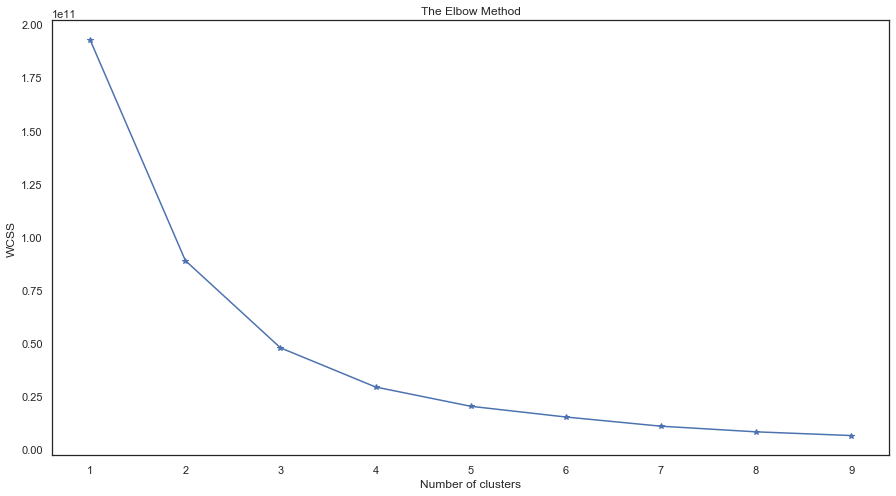

In [62]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_rfm_log)
    wcss.append(kmeans.inertia_)

f, ax = plt.subplots(figsize=(15, 8))  
plt.style.use('_classic_test_patch')  
plt.plot(range(1, 10), wcss, '-*')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS');

#### Observation:

We can see there is a sharp turn from the 4 point. We can select values between 4 to 6 for our clusters.

Lets plot all the clusters 4, 5 & 6 to see which is defined better.



In [63]:
(df_rfm[df_rfm["Frequency"]>1].shape[0]/32951)*100

50.854298807319964

#### From this above calculation we can say that around 49% customers are one time customers and only 51% are recurring customers.

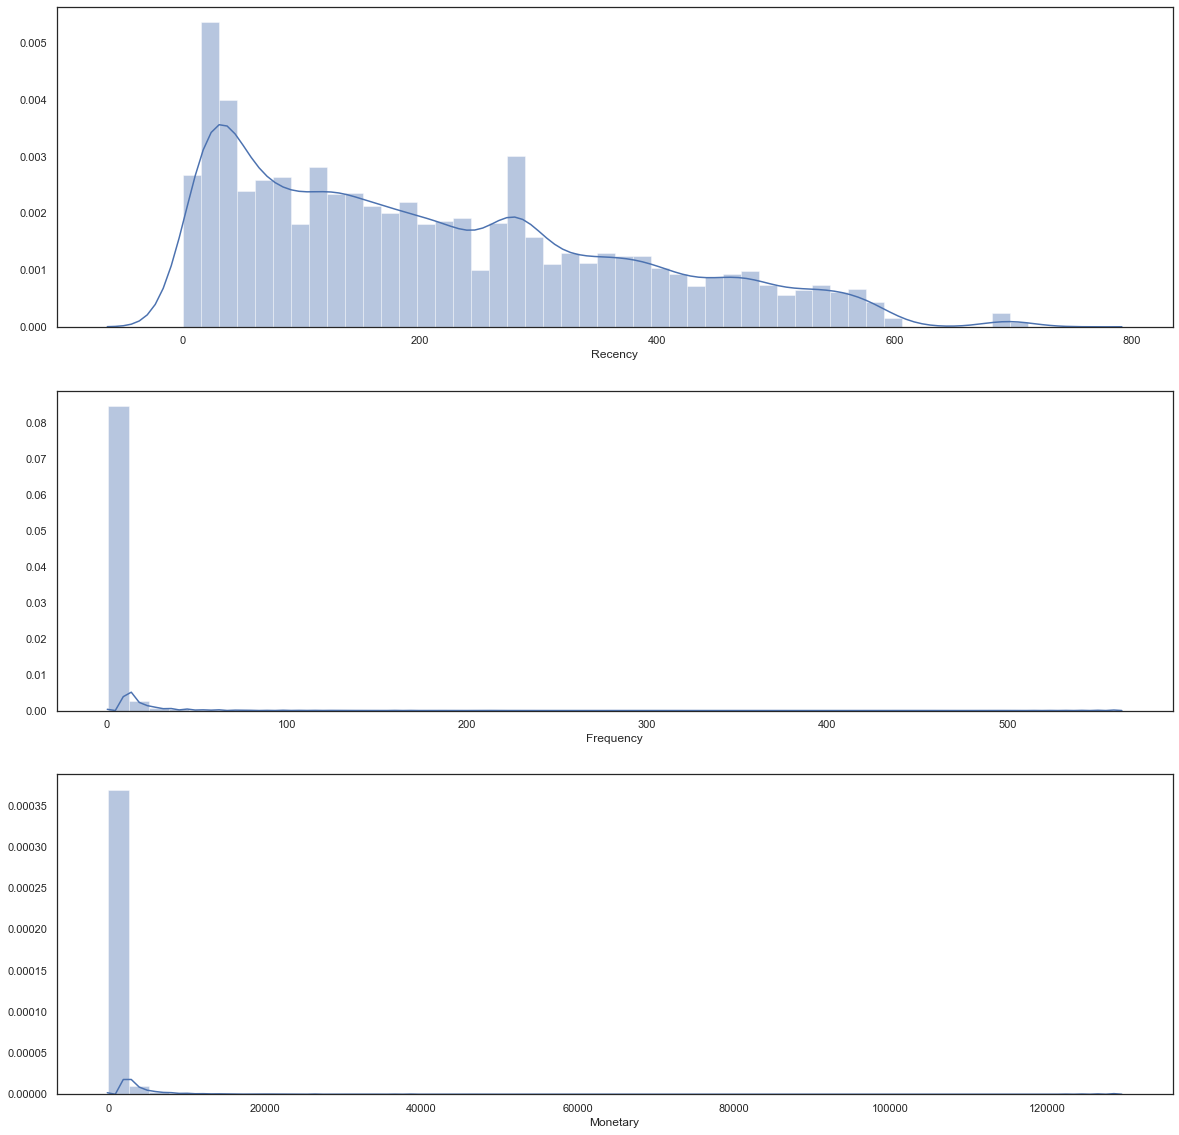

In [64]:
#plot RFM distribution
plt.figure(figsize=(20,20))
#plot distribution of Recency
plt.subplot(3,1,1);
sns.distplot(df_rfm["Recency"])

#plot distribution of Frequency
plt.subplot(3,1,2);
sns.distplot(df_rfm["Frequency"])

#plot distribution of Monetary
plt.subplot(3,1,3);
sns.distplot(df_rfm["Monetary"])

In [65]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(df_rfm_log)
cluster_labels = kmeans.labels_
data_rfm_k4 = df_rfm_log.assign(Cluster=cluster_labels)
grouped = data_rfm_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0         214.8       2.9    398.3  31825
1          98.7      84.9  25228.7     83
2          67.3     307.6  72558.3     16
3         136.1      24.2   5902.4   1027

In [66]:
data_melt = pd.melt(
                    data_rfm_k4.reset_index(),               
                    id_vars=['product_id', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                    var_name='Metric', value_name='Value'
                    )
data_melt.head(10)

,product_id,Cluster,Metric,Value
0,00066f42aeeb9f3007548bb9d3f33c38,0,Recency,105.0
1,00088930e925c41fd95ebfe695fd2655,0,Recency,264.0
2,0009406fd7479715e4bef61dd91f2462,0,Recency,255.0
3,000b8f95fcb9e0096488278317764d19,0,Recency,23.0
4,000d9be29b5207b54e86aa1b1ac54872,0,Recency,152.0
5,0011c512eb256aa0dbbb544d8dffcf6e,0,Recency,262.0
6,00126f27c813603687e6ce486d909d01,0,Recency,350.0
7,001795ec6f1b187d37335e1c4704762e,0,Recency,250.0
8,001b237c0e9bb435f2e54071129237e9,0,Recency,25.0
9,001b72dfd63e9833e8c02742adf472e3,0,Recency,261.0


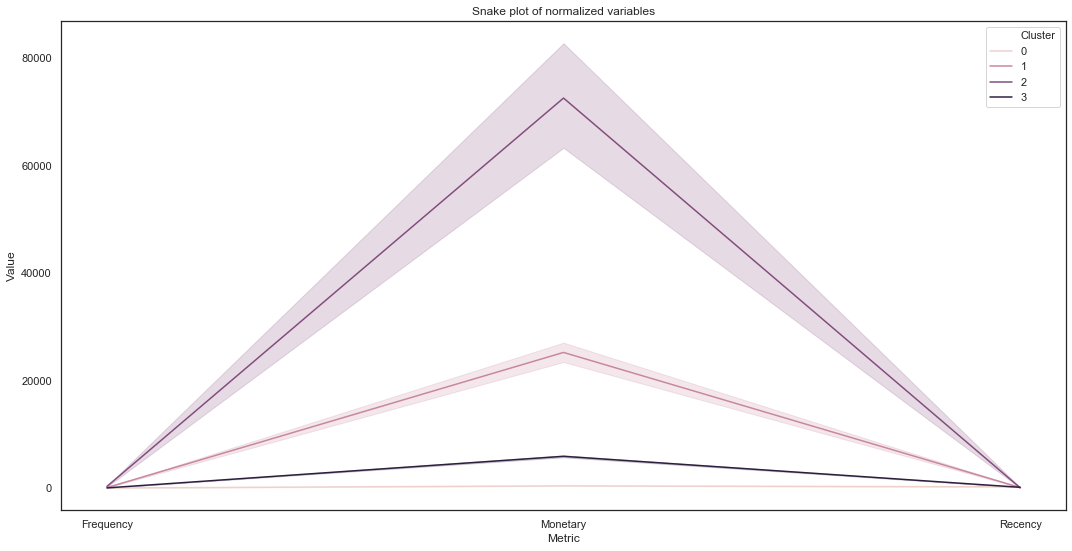

In [67]:
# Snake Plot
plt.figure(figsize = (18,9))
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

## Relative Importance of RFM among K-Means Clusters
We can see that our grouped summary of the mean of R, F, M that each cluster of customers places a different emphasis on our 4 features:

### Cluster 0
It has the highest MontaryValue mean and low Recency mean and the highest frequency mean — This is our ideal customer segment

### Cluster 1
It performs poorly across R, F, and M. we will need to design campaigns to activate them again.

### Cluster 2
They shopped with us recently but have not spend as much or as frequently as we would like them to — perhaps some personalization of products targeted at them can help to maximize their lifetime-value and come back to purchase?

### Cluster 3
It has spent quite a fair amount with us but has not shopped with us in the 3–4 months — We will need to do something before we lose them!

## RFM Quartiles
The simples way to create customers segments from RFM model is to use quartiles.We assign score from 1 to 4 to Recency,Frequency and Monetary.4 is the best/heighest value, and 1 is the lowest/worst value. A RFM scoreis calculated simply by combining individual RFM score numbers.

In [68]:
quantiles=df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Recency': {0.25: 73.0, 0.5: 181.0, 0.75: 320.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'Monetary': {0.25: 97.23500000000001, 0.5: 210.56, 0.75: 522.58}}

We will create two segmentation classes since high recency is bad, while high frequency and monetary value is good.

In [69]:
#x=value, p=recency,frequency, monetary_value,  d=quartiles dict
def RScore(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

# x=value, p=recency,frequency, monetary_value,  k=quartiles dict
def FMScore(x,p,k):
    if x<=k[p][0.25]:
        return 1
    elif x<=k[p][0.50]:
        return 2
    elif x<=k[p][0.75]:
        return 3
    else:
        return 4

In [70]:
#create RFM segmentation table
rfm_segmentation=df_rfm
rfm_segmentation['R_Quartile']=rfm_segmentation["Recency"].apply(RScore,args=('Recency',quantiles))
rfm_segmentation['F_Quartile']=rfm_segmentation["Frequency"].apply(FMScore,args=('Frequency',quantiles))
rfm_segmentation['M_Quartile']=rfm_segmentation["Monetary"].apply(FMScore,args=('Monetary',quantiles))

In [71]:
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
product_id,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,105,1,120.24,3,1,2
00088930e925c41fd95ebfe695fd2655,264,1,143.83,2,1,2
0009406fd7479715e4bef61dd91f2462,255,1,242.10,2,1,3
000b8f95fcb9e0096488278317764d19,23,2,157.00,4,2,2
000d9be29b5207b54e86aa1b1ac54872,152,1,218.27,3,1,3
...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,364,2,285.39,1,2,3
fff81cc3158d2725c0655ab9ba0f712c,34,1,97.89,4,1,2
fff9553ac224cec9d15d49f5a263411f,331,1,43.85,1,1,1


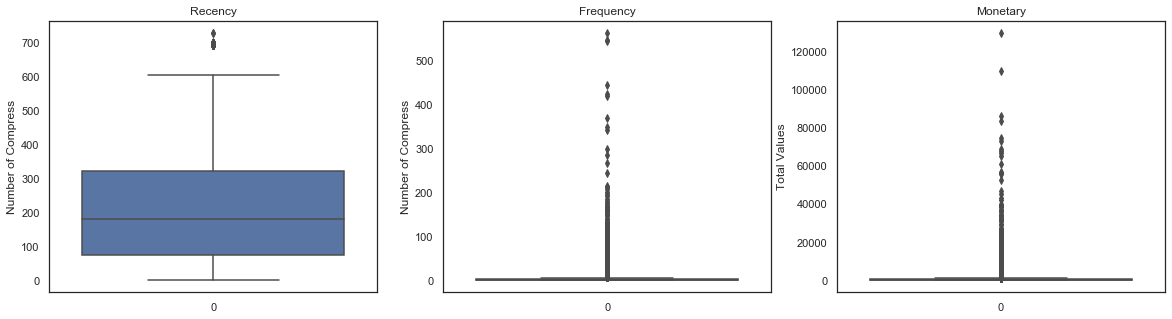

In [72]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(data=df_rfm['Recency'])
plt.title('Recency')
plt.ylabel('Number of Compress')
plt.subplot(1,3,2)
sns.boxplot(data=df_rfm['Frequency'])
plt.title('Frequency')
plt.ylabel('Number of Compress')
plt.subplot(1,3,3)
sns.boxplot(data=df_rfm['Monetary'])
plt.title('Monetary')
plt.ylabel('Total Values')
plt.show()

In [73]:
rfm_segmentation['RFMScore']=rfm_segmentation.R_Quartile.map(str)+rfm_segmentation.F_Quartile.map(str)+rfm_segmentation.M_Quartile.map(str)
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,105,1,120.24,3,1,2,312
00088930e925c41fd95ebfe695fd2655,264,1,143.83,2,1,2,212
0009406fd7479715e4bef61dd91f2462,255,1,242.10,2,1,3,213
000b8f95fcb9e0096488278317764d19,23,2,157.00,4,2,2,422
000d9be29b5207b54e86aa1b1ac54872,152,1,218.27,3,1,3,313
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,364,2,285.39,1,2,3,123
fff81cc3158d2725c0655ab9ba0f712c,34,1,97.89,4,1,2,412
fff9553ac224cec9d15d49f5a263411f,331,1,43.85,1,1,1,111


In [74]:
def segment(x):
    if x in ['444','443','433','442','434']:
        return 'Best_customer'
    elif x in [ '432','341','342','332','333','344','343','441']:
        return 'Loyal_customer'
    elif x in ['334', '234','214','224','413','314','244','243']:
        return 'Big_spender'
    elif x in ['212', '213', '222','211','114','311','312','214','143','142','141','241']:
        return 'Almost_lost'
    elif x in ['111', '121','112','113','144']:
        return 'Lost_customer'
    else:
        return 'New_customer'

In [75]:
rfm_segmentation['segments'] = rfm_segmentation['RFMScore'].apply(segment)
rfm_segmentation['segments'].value_counts()

New_customer      10066
Almost_lost        8039
Lost_customer      5407
Big_spender        3379
Best_customer      3255
Loyal_customer     2805
Name: segments, dtype: int64

In [76]:
segmentwise = rfm_segmentation.groupby('segments').agg(RecencyMean = ('Recency', 'mean'),
                                          FrequencyMean = ('Frequency', 'mean'),
                                          MonetaryMean = ('Monetary', 'mean'),
                                          GroupSize = ('Recency', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segments,,,,
Almost_lost,225.067546,1.337604,170.661271,8039
Best_customer,32.329647,14.241167,2223.521705,3255
Big_spender,190.103285,4.723587,1210.660994,3379
Lost_customer,444.497133,2.079342,402.243784,5407
Loyal_customer,119.479857,8.973975,1440.694816,2805
New_customer,167.890920,1.799523,305.616695,10066


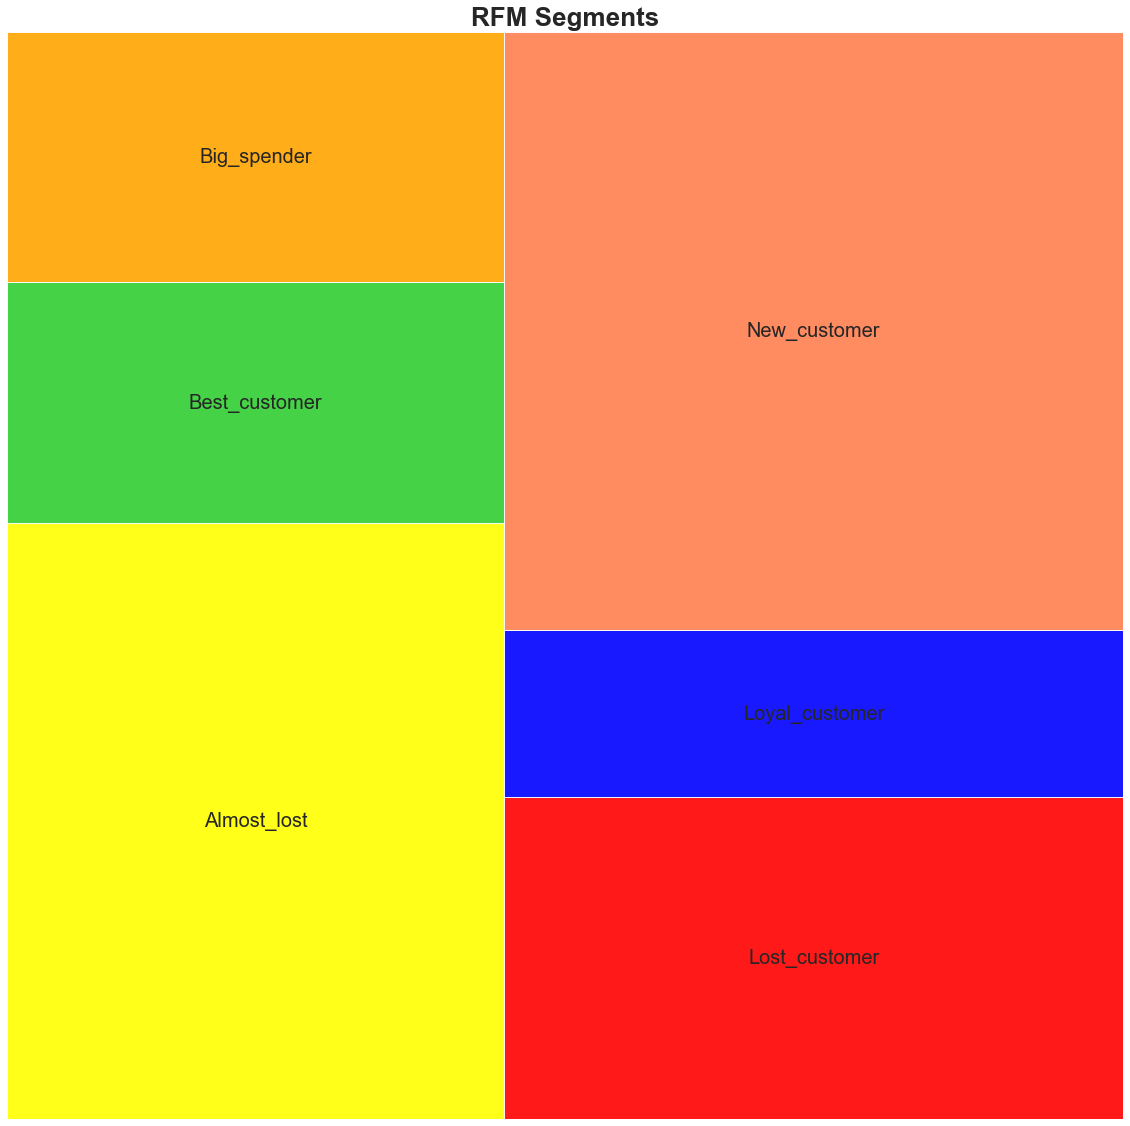

In [77]:
import squarify

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 20)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['yellow', 'limegreen', 'orange', 'red', 'blue', 'coral'],
              alpha = 0.9,text_kwargs={'fontsize':20})
plt.title("RFM Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

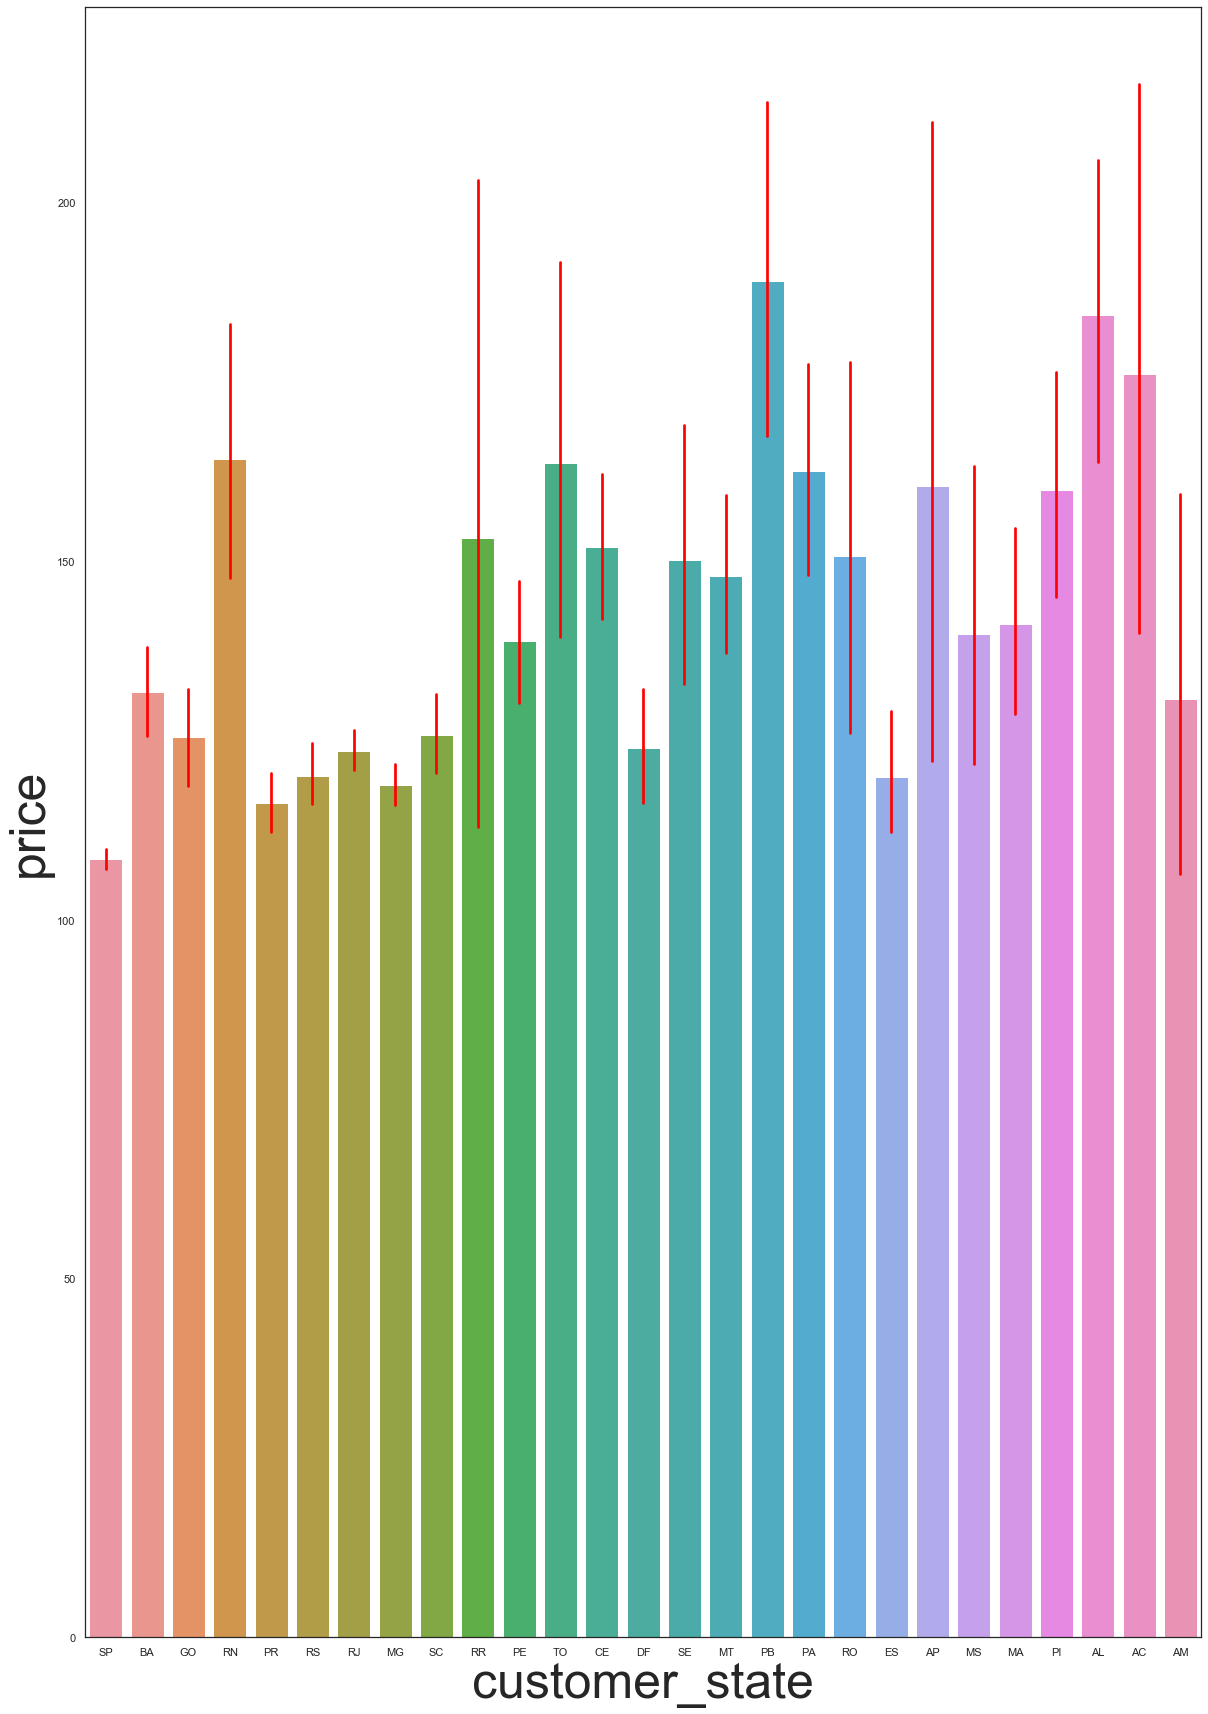

In [78]:
plt.figure(figsize=(20,30))
sns.barplot(x='customer_state',y='price',data=ord_final,errcolor='red')
plt.xlabel('customer_state',fontsize=50)
plt.ylabel('price',fontsize=50)

plt.show()

In [79]:
ord_final.product_category_name.value_counts().unique()

array([95727,  3389,  3094,  2641,  2504,  2461,  1926,  1685,  1318,
        1187,  1183,  1070,   933,   873,   762,   740,   678,   556,
         308,   282,   249,   239,   202,   184,   171,   143,   127,
         123,   113,   109,   105,   103,   100,    93,    86,    83,
          79,    75,    73,    71,    69,    68,    66,    64,    62,
          55,    32,    31,    25,    24,    18,    17,    15,    12,
          11,     8,     5,     4,     2,     1])

In [80]:
ord_final.product_category_name.value_counts()

toys                                 95727
health_beauty                         3389
bed_bath_table                        3094
sports_leisure                        2641
furniture_decor                       2504
                                     ...  
furniture_mattress_and_upholstery        2
fashion_childrens_clothes                2
diapers_and_hygiene                      1
home_comfort_2                           1
security_and_services                    1
Name: product_category_name, Length: 70, dtype: int64

In [81]:
# Get the top 10 profitable items by using position based indexing. Specify the rows till 10 (0-9)
ord_final.iloc[:10]


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration,customer_zip_code_prefix,...,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
3,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
4,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
5,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,0,8 days 10:28:40,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,housewares,500.0,19.0,8.0,13.0
6,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,0,1 days 07:53:42,3149,...,1.0,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,35.39,8.72,baby,350.0,19.0,14.0,12.0
7,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,0,1 days 07:53:42,3149,...,1.0,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,35.39,8.72,baby,350.0,19.0,14.0,12.0
8,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,0,13 days 18:46:08,47813,...,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,toys,400.0,19.0,13.0,19.0
9,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,0,9 days 09:27:40,75265,...,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,toys,420.0,24.0,19.0,21.0


In [82]:
# Checking the dates of the first and last purchase
print('Data min: {} \nData max: {}'.format(ord_final['order_purchase_timestamp'].min(), 
                                                 ord_final['order_purchase_timestamp'].max()))

Data min: 2016-09-04 21:15:19 
Data max: 2018-10-17 17:30:18


In [83]:
df.groupby([ord_final['order_purchase_timestamp'].dt.year,
           ord_final['order_purchase_timestamp'].dt.month]).count()

Dataset name  Column Name  \
order_purchase_timestamp order_purchase_timestamp                              
2016                     10                                   2            2   
2017                     1                                    1            1   
                         4                                    1            1   
                         5                                    3            3   
                         7                                    4            4   
                         9                                    2            2   
                         10                                   6            6   
                         11                                   1            1   
2018                     2                                    1            1   
                         3                                    1            1   
                         6                                    3            3   
                         7                                    2            2   
                         8                                    1            1   

                                                   Description  
order_purchase_timestamp order_purchase_timestamp               
2016                     10                                  2  
2017                     1                                   1  
                         4                                   1  
                         5                                   3  
                         7                                   4  
                         9                                   2  
                         10                                  6  
                         11                                  1  
2018                     2                                   1  
                         3                                   1  
                         6                                   3  
                         7                                   2  
                         8                                   1

### Note 
That in 2016 we have some values ​​that are not consistent with the rest of the months. Therefore, we will disregard such values ​​and create the model using the entire year of 2017 and the nine months of 2018.

### Note 
Also from the above result, it is possible to see that the data for 2016 add up to 370 records. So, we will sort these dates, create a list with the indexes of all 370 records and delete those lines.

In [84]:
# Creating a list with indexes
year_2016_index = ord_final['order_purchase_timestamp'].sort_values().index[:370]
year_2016_index

Int64Index([  7262,   7263,   7086,  15428,  44948,  44947,  44949, 109888,
             77458,  77456,
            ...
             68378,  68379,  11989,  11988,  53577, 121605, 100915,  74038,
             74037,  25212],
           dtype='int64', length=370)

### Plotting time series behavior
Now, we will define two databases:

1) Considering the amount of products that were sold per month.

2) Considering the amount obtained per month.

Next, we will make a graph for each situation to understand the behavior of the series in both cases.

Plotting data for the amount of products sold monthly

In [85]:
ord_group_quant = ord_final.groupby(ord_final['order_purchase_timestamp']).count()['order_id']
ord_group_quant

order_purchase_timestamp
2016-09-04 21:15:19    2
2016-09-05 00:15:34    1
2016-09-13 15:24:19    1
2016-09-15 12:16:38    3
2016-10-02 22:07:52    1
                      ..
2018-09-29 09:13:03    1
2018-10-01 15:30:09    2
2018-10-03 18:55:29    3
2018-10-16 20:16:02    2
2018-10-17 17:30:18    1
Name: order_id, Length: 98875, dtype: int64

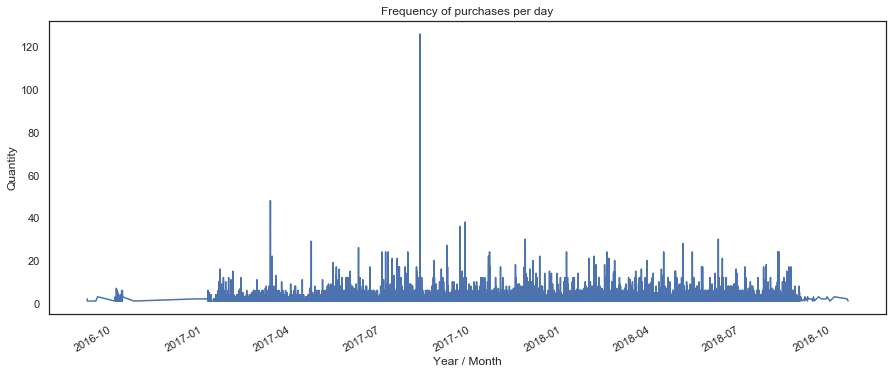

In [86]:
ord_group_quant.plot(figsize=(15,6))
plt.title('Frequency of purchases per day')
plt.xlabel('Year / Month')
plt.ylabel('Quantity')
plt.show()

In [87]:
ord_group_price = ord_final.groupby(ord_final['order_purchase_timestamp']).sum()['price']
ord_group_price

order_purchase_timestamp
2016-09-04 21:15:19     72.89
2016-09-05 00:15:34     59.50
2016-09-13 15:24:19      0.00
2016-09-15 12:16:38    134.97
2016-10-02 22:07:52    100.00
                        ...  
2018-09-29 09:13:03      0.00
2018-10-01 15:30:09      0.00
2018-10-03 18:55:29      0.00
2018-10-16 20:16:02      0.00
2018-10-17 17:30:18      0.00
Name: price, Length: 98875, dtype: float64

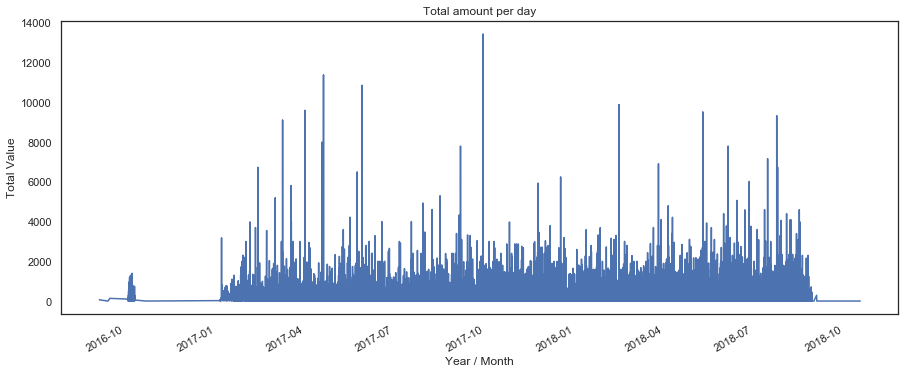

In [88]:
ord_group_price.plot(figsize=(15,6))
plt.title('Total amount per day')
plt.xlabel('Year / Month')
plt.ylabel('Total Value')
plt.show()

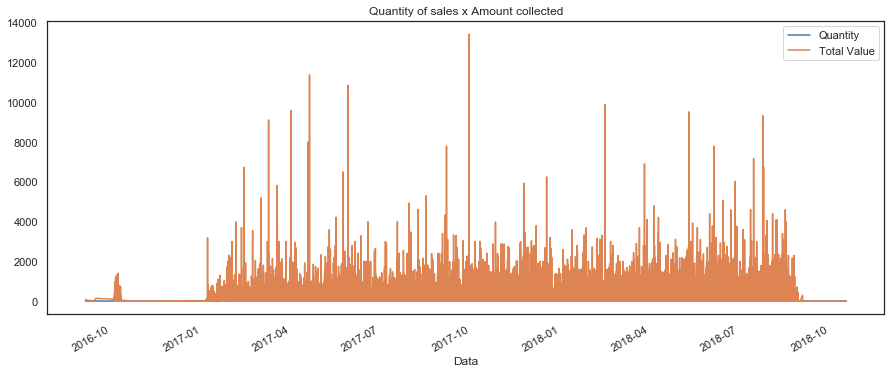

In [89]:
# Plotando ambos os gráficos juntos
ord_group_quant.plot(figsize=(15,6), label='Quantity')
ord_group_price.plot(figsize=(15,6), label='Total Value')
plt.title('Quantity of sales x Amount collected')
plt.xlabel('Data')
plt.legend(loc='best')
plt.show()

### Note 
That although both graphs are very similar, they are presented in very different scales, which makes the quantity graph practically straight line in relation to the price graph.

In [90]:
pip install Lifetimes

Note: you may need to restart the kernel to use updated packages.


In [91]:
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

In [92]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [93]:
transaction_data= ord_final[ord_final['customer_id']=='004288347e5e88a27ded2bb23747066c']
transaction_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delayed,delivery_time_duration,customer_zip_code_prefix,...,order_item_id,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
48905,a61d617fbe5bd006e40d3a0988fc844b,004288347e5e88a27ded2bb23747066c,delivered,2017-07-27 14:13:03,2017-07-27 14:25:14,2017-08-04 16:26:54,2017-08-18,0,8 days 02:13:51,26220,...,1.0,6e1b14d3cbb5fb3a2c00351007127dfd,7a67c85e85bb2ce8582c35f2203ad736,229.99,21.10,cool_stuff,1625.0,44.0,24.0,32.0
48906,a61d617fbe5bd006e40d3a0988fc844b,004288347e5e88a27ded2bb23747066c,delivered,2017-07-27 14:13:03,2017-07-27 14:25:14,2017-08-04 16:26:54,2017-08-18,0,8 days 02:13:51,26220,...,1.0,6e1b14d3cbb5fb3a2c00351007127dfd,7a67c85e85bb2ce8582c35f2203ad736,229.99,21.10,cool_stuff,1625.0,44.0,24.0,32.0
48907,08204559bebd39e09ee52dcb56d8faa2,004288347e5e88a27ded2bb23747066c,delivered,2018-01-14 07:36:54,2018-01-14 07:49:28,2018-01-19 22:14:14,2018-02-09,0,5 days 14:37:20,26220,...,1.0,a2bd2eae20998a24c22b110334928b02,6cd68b3ed6d59aaa9fece558ad360c0a,87.90,15.38,luggage_accessories,700.0,19.0,48.0,35.0
48908,08204559bebd39e09ee52dcb56d8faa2,004288347e5e88a27ded2bb23747066c,delivered,2018-01-14 07:36:54,2018-01-14 07:49:28,2018-01-19 22:14:14,2018-02-09,0,5 days 14:37:20,26220,...,1.0,a2bd2eae20998a24c22b110334928b02,6cd68b3ed6d59aaa9fece558ad360c0a,87.90,15.38,luggage_accessories,700.0,19.0,48.0,35.0


In [94]:
import plotly.graph_objects as go

In [95]:
transaction_data = pd.merge(order,order_items,'inner','order_id')
transaction_data = transaction_data[['customer_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [96]:
summary = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='price')
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.818576
std,0.178936,25.263074,153.656402,29.891892
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,2040.000000


In [97]:
summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [98]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [99]:
transaction_data[transaction_data['customer_id']=='004288347e5e88a27ded2bb23747066c']

,customer_id,price,date
38145,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
45322,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


In [100]:
summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

In [101]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

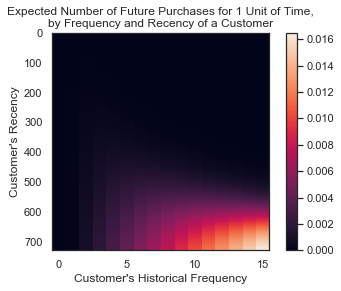

In [102]:
plot_frequency_recency_matrix(bgf);


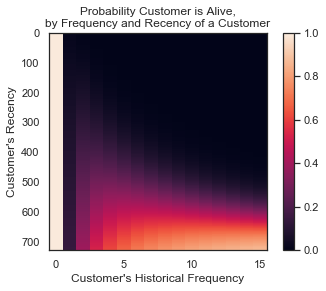

In [103]:
plot_probability_alive_matrix(bgf);


### Training a model and evaluating model performance
Next we want to evaluate the model to see how well it performs in the future. I'll split the data into a training (calibration) period and a holdout (observation) period, train the BG/NBD model and evaluate performance with four plots that Peter Fader outlines in this talk (@ 26:10). These plots are:

1) Calibration period histogram: does the model fit the training data?

2) Cumulative transaction plot: does the model predict cumulative sales well?

3) Incremental transaction plot: does the model capture the overall trend in transactions?

4) Conditional expectations plot: can the model predict the number of purchases a customer will make based on the training data?



### 1) Calibration period histogram

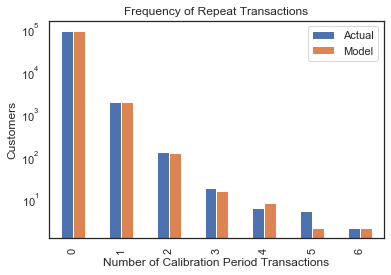

In [104]:
plot_period_transactions(bgf).set_yscale('log');

The model is fairly representative of the real data up until four repeat transactions. There are few customers who make more purchases.



### Cumulative transaction plot

In [105]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_id', 'date',
                                        calibration_period_end='2017-09-03',
                                        observation_period_end='2018-09-03' )


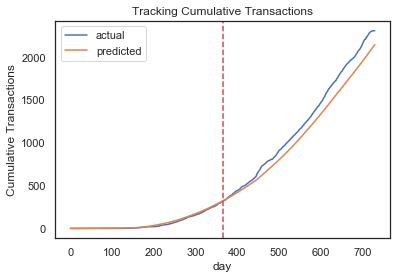

In [106]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf,transaction_data,'date','customer_id',730,365);

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model does a pretty swell job at predicting cumulative transactions.

### 3) Incremental transaction plot

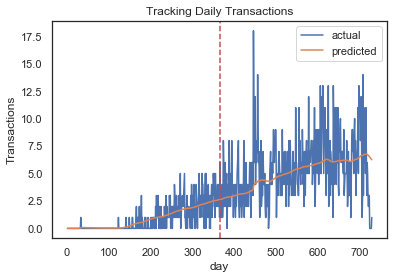

In [107]:
plot_incremental_transactions(bgf,transaction_data,'date','customer_id',730,365);

This plot shows that the model does a decent job capturing general trends in the data.

### 4) Conditional expectations plot

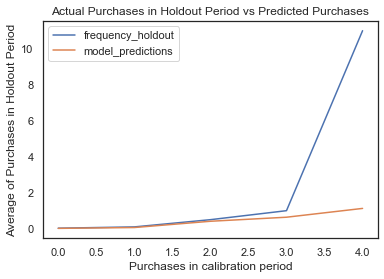

In [108]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

The model performs well up to three calibration period purchases, but diverges from the holdout data because of the distribution of the data.

In [109]:
ord_final.groupby(by=['order_id','product_category_name'])['order_item_id'].count().unstack().reset_index().set_index('order_id')

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
00018f77f2f0320c557190d7a144bdd3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
000229ec398224ef6ca0657da4fc703e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
00024acbcdf0a6daa1e931b038114c75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
00042b26cf59d7ce69dfabb4e55b4fd9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffcd46ef2263f404302a634eb57f7eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
fffce4705a9662cd70adb13d4a31832d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [110]:
prd_category=ord_final.groupby(by=['order_id','product_category_name'])['order_item_id'].count().unstack().reset_index().set_index('order_id').fillna(0)
prd_category

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00018f77f2f0320c557190d7a144bdd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
000229ec398224ef6ca0657da4fc703e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00024acbcdf0a6daa1e931b038114c75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00042b26cf59d7ce69dfabb4e55b4fd9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffcd46ef2263f404302a634eb57f7eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
fffce4705a9662cd70adb13d4a31832d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
#Encoding data
def encode_data(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
basket_encode = prd_category.applymap(encode_data)
basket_encode

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00018f77f2f0320c557190d7a144bdd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00024acbcdf0a6daa1e931b038114c75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fffcd46ef2263f404302a634eb57f7eb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
fffce4705a9662cd70adb13d4a31832d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


[Text(0, 0, 'toys'),
 Text(0, 0, 'health_beauty'),
 Text(0, 0, 'bed_bath_table'),
 Text(0, 0, 'sports_leisure'),
 Text(0, 0, 'computers_accessories'),
 Text(0, 0, 'furniture_decor'),
 Text(0, 0, 'watches_gifts'),
 Text(0, 0, 'housewares'),
 Text(0, 0, 'telephony'),
 Text(0, 0, 'auto')]

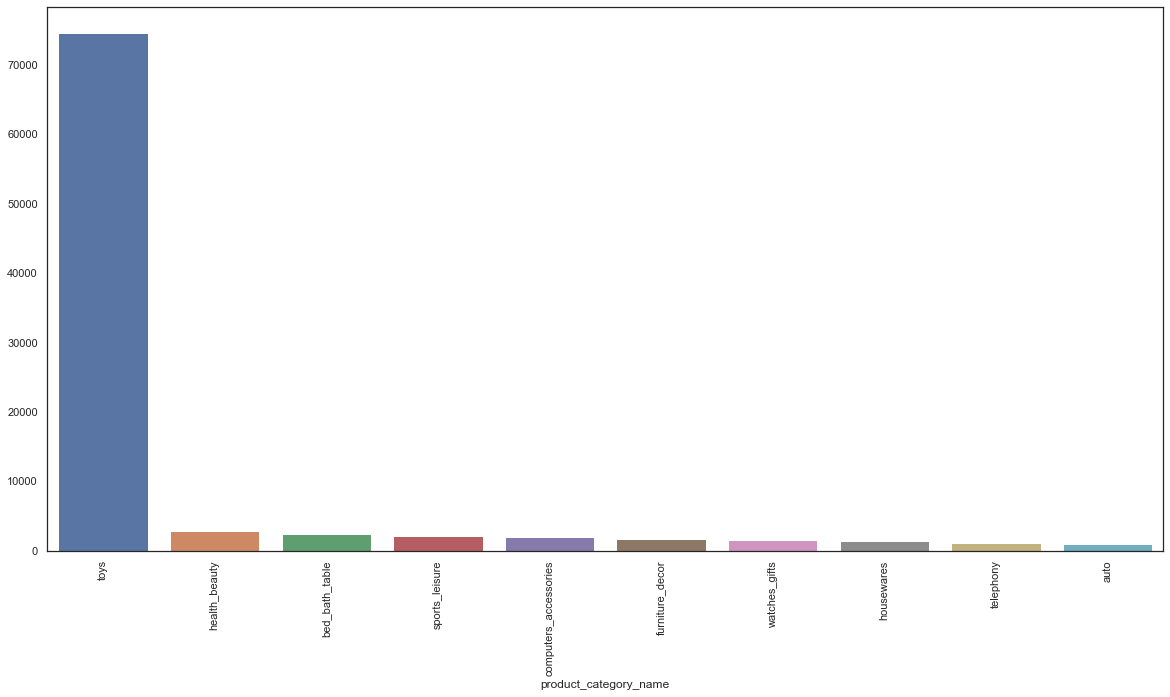

In [112]:
##Lets consider the top 10 items purchased freequently
r=basket_encode.sum(axis=0).sort_values(ascending=False)[:10]
#altering the figsize
plt.figure(figsize=(20,10))
s=sns.barplot(x=r.index,y=r.values)
s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [113]:
basket_encode = basket_encode[(basket_encode>0).sum(axis=1)>=2]
basket_encode

product_category_name,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00337fe25a3780b3424d9ad7c5a4b35e,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
00946f674d880be1f188abc10ad7cf46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00bcee890eba57a9767c7b5ca12d3a1b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
01144cadcf64b6427f0a6580a3033220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
013a98b3a668bcef05b98898177f6923,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff632bc583a94f23c59db4cbaa0ba2ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ffa466d3e55f98477b7e0da764df3c6c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ffb9a9cd00c74c11c24aa30b3d78e03b,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [114]:
from mlxtend.frequent_patterns import apriori

#Apply apriori algorithm to data with min. support threeshold of 0.01

frequent_itemsets = apriori(basket_encode, min_support = 0.01)
frequent_itemsets

,support,itemsets
0,0.031563,(5)
1,0.019246,(6)
2,0.230177,(7)
3,0.083911,(14)
4,0.010008,(16)
5,0.020785,(19)
6,0.033102,(27)
7,0.127791,(38)
8,0.041570,(41)
9,0.066975,(42)


Out of 36, 19 itemsets with a support of greater than 0.01 contain a single item.

In [115]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Apply apriori algorithm to data with min support threshold of 0.001.
frequent_itemsets = apriori(basket_encode, min_support = 0.01, use_colnames = True)

# Print frequent itemsets.
frequent_itemsets

,support,itemsets
0,0.031563,(auto)
1,0.019246,(baby)
2,0.230177,(bed_bath_table)
3,0.083911,(computers_accessories)
4,0.010008,(construction_tools_construction)
5,0.020785,(cool_stuff)
6,0.033102,(fashion_bags_accessories)
7,0.127791,(furniture_decor)
8,0.041570,(garden_tools)
9,0.066975,(health_beauty)


In [116]:
from mlxtend.frequent_patterns import association_rules


In [117]:
# Recover association rules using support and a minimum threshold of 0.0001.
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold =0.0001 )

# Print rules header.
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(toys),(auto),0.971517,0.031563,0.030793,0.031696,1.004213,0.000129,1.000137
1,(auto),(toys),0.031563,0.971517,0.030793,0.975610,1.004213,0.000129,1.167821
2,(toys),(baby),0.971517,0.019246,0.016166,0.016640,0.864628,-0.002531,0.997351
3,(baby),(toys),0.019246,0.971517,0.016166,0.840000,0.864628,-0.002531,0.178022
4,(toys),(bed_bath_table),0.971517,0.230177,0.226328,0.232964,1.012106,0.002707,1.003633


### Pruning association rules

In [118]:
# Recover association rules using confidence threshold of 0.01.
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.01)

# Print rules.
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(toys),(auto),0.971517,0.031563,0.030793,0.031696,1.004213,0.000129,1.000137
1,(auto),(toys),0.031563,0.971517,0.030793,0.975610,1.004213,0.000129,1.167821
2,(toys),(baby),0.971517,0.019246,0.016166,0.016640,0.864628,-0.002531,0.997351
3,(baby),(toys),0.019246,0.971517,0.016166,0.840000,0.864628,-0.002531,0.178022
4,(toys),(bed_bath_table),0.971517,0.230177,0.226328,0.232964,1.012106,0.002707,1.003633
5,(bed_bath_table),(toys),0.230177,0.971517,0.226328,0.983278,1.012106,0.002707,1.703310
6,(toys),(computers_accessories),0.971517,0.083911,0.080062,0.082409,0.982102,-0.001459,0.998363
7,(computers_accessories),(toys),0.083911,0.971517,0.080062,0.954128,0.982102,-0.001459,0.620939
8,(toys),(cool_stuff),0.971517,0.020785,0.018476,0.019017,0.914950,-0.001717,0.998198
9,(cool_stuff),(toys),0.020785,0.971517,0.018476,0.888889,0.914950,-0.001717,0.256351


In [119]:
# Select rules with a consequent support above 0.095.
rules = rules[rules['consequent support'] > 0.095]

# Print rules.
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(auto),(toys),0.031563,0.971517,0.030793,0.975610,1.004213,0.000129,1.167821
3,(baby),(toys),0.019246,0.971517,0.016166,0.840000,0.864628,-0.002531,0.178022
4,(toys),(bed_bath_table),0.971517,0.230177,0.226328,0.232964,1.012106,0.002707,1.003633
5,(bed_bath_table),(toys),0.230177,0.971517,0.226328,0.983278,1.012106,0.002707,1.703310
7,(computers_accessories),(toys),0.083911,0.971517,0.080062,0.954128,0.982102,-0.001459,0.620939
9,(cool_stuff),(toys),0.020785,0.971517,0.018476,0.888889,0.914950,-0.001717,0.256351
11,(fashion_bags_accessories),(toys),0.033102,0.971517,0.032333,0.976744,1.005381,0.000173,1.224788
12,(toys),(furniture_decor),0.971517,0.127791,0.120092,0.123613,0.967311,-0.004058,0.995234
13,(furniture_decor),(toys),0.127791,0.971517,0.120092,0.939759,0.967311,-0.004058,0.472825
15,(garden_tools),(toys),0.041570,0.971517,0.034642,0.833333,0.857765,-0.005744,0.170901


### The leverage metric
Leverage provides a sanity check.  𝑠𝑢𝑝𝑝𝑜𝑟𝑡(𝑎𝑛𝑡𝑒𝑐𝑒𝑑𝑒𝑛𝑡,𝑐𝑜𝑛𝑠𝑒𝑞𝑢𝑒𝑛𝑡)  = joint support in data.  𝑠𝑢𝑝𝑝𝑜𝑟𝑡(𝑎𝑛𝑡𝑒𝑐𝑒𝑑𝑒𝑛𝑡)∗𝑠𝑢𝑝𝑝𝑜𝑟𝑡(𝑐𝑜𝑛𝑠𝑒𝑞𝑢𝑒𝑛𝑡)  = expected joint support for unrelated antecedent and consequent.
### Leverage formula
$$leverage(antecendent, consequent) = 
support(antecedent, consequent) - support(antecedent) * support(consequent)$$
### For most problems, we will discard itemsets with negative leverage.
Negative leverage means that the items appear together less frequently than we would expect if they were randomly and independently distributed across transactions.


In [120]:
# select rules with leverage higher than 0.0
rules=rules[rules["leverage"]>0.0]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(auto),(toys),0.031563,0.971517,0.030793,0.975610,1.004213,0.000129,1.167821
4,(toys),(bed_bath_table),0.971517,0.230177,0.226328,0.232964,1.012106,0.002707,1.003633
5,(bed_bath_table),(toys),0.230177,0.971517,0.226328,0.983278,1.012106,0.002707,1.703310
11,(fashion_bags_accessories),(toys),0.033102,0.971517,0.032333,0.976744,1.005381,0.000173,1.224788
29,(stationery),(toys),0.023865,0.971517,0.023865,1.000000,1.029319,0.000680,inf
31,(telephony),(toys),0.024634,0.971517,0.024634,1.000000,1.029319,0.000702,inf
33,(watches_gifts),(toys),0.057737,0.971517,0.056197,0.973333,1.001870,0.000105,1.068129


Intuition we can get is that:

1. 98% of transactions containing bed_bath_table also contain toys
2. 24% of transactions containing toys also contain bed_bath_table
3. 97% of transactions containing fashion_bags_accessories also contain toys
There is more chance of the transaction {stationery,toys} or {telephony,toys} than other as we can find the interesting nature of rule by comparing lift,leverage and conviction. A rule is said to be interesting if it is unexpected(suprising to user) and/or actionable(user can do something with it).It's a subjective measure.

# Conclusion

### As per the analysis, below mentioned are the insights
   1. Toys which holds 20% of the items generates 80% of the revenue
   2. 18.4 % of the customers are recurring, whereas 40% of the customers are either lost or on the verge of leaving. Thus we need to look at the core issues, what is leading to this loss.
   3. 30.5 % of the customers have joined recently, adding upto a good amount of revenue
   4. Looking at the purchases, Tillnow the most revenue was generated in the month of Oct,2017 with the largest quantity of sales
   5. Based on Aprirori, categorisation of products been done. Hence, leading to easy and structured access of products on the app
   6. Using Kmeans, we worked on Expectation Maximization, giving a best case scenario of 4 in Recency, Frequency and Monetary 
   7. Frequency Holdouts are in better stage wrt to Model Predictions